In [21]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate, QFT

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [22]:
def create_hamiltonian(qubits, g, show_steps=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)
    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if show_steps: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        H += -temp.to_matrix()
        if show_steps: print("-"+str(temp)+" ", end='')
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        H += -g*temp.to_matrix()
        if show_steps: print("-"+str(g)+"*"+str(temp)+" ", end='')
    if show_steps: print("\n")
    
    if show_steps:
        eigenvalues = np.linalg.eigvals(H)
        print("Original eigenvalues:", eigenvalues)
    
    # scale eigenvalues of the Hamiltonian
    scale_factor = (3/4) *pi
    H = scale_factor*H / np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite (not nessary in this usecase)
    # H += pi*np.eye(2**qubits)

    if show_steps:
        eigenvalues = np.linalg.eigvals(H)
        print("Scaled eigenvalues of the hamiltonian:\n", np.linalg.eigvals(H))
        min_eigenvalue = np.min(eigenvalues)
        print("Lowest energy eigenvalue", min_eigenvalue); print()

    return H

def hadamard_test(ham, t, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def hadamard_test(ham, t, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def create_hadamard_test(ham, t, backend = AerSimulator(), W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    trans_qc = transpile(qc, backend)
    return trans_qc

def run_circuit(trans_qc, shots = 1000, backend = AerSimulator()):
    counts = backend.run(trans_qc, shots = shots).result().get_counts()
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas



In [23]:
def generate_s_k(ham, Dt, K, g=0):
    s_k = []
    for i in range(2*K+1):
        s_k.append(hadamard_test(ham, i*Dt, g=g))
    return s_k

def transpile_s_k(ham, Dt, K, g=0):
    trans_qcs = []
    for i in range(2*K+1):
        trans_qcs.append(create_hadamard_test(ham, i*Dt, g=g))
    return trans_qcs


'''
start: where to start reading the data from
k: number of columns
d: how much data per column
s_k: quantum data to create matrix
'''
def make_X(start, k, d, s_k):
    X = np.zeros((d, k))
    for i in range(len(X)):
        for j in range(len(X[i])):
            # print(i+j+start)
            X[i][j] = s_k[i+j+start]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = np.linalg.svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    for l in range(len(sigma)):
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the singular value
            U[:,l] = 0   # remove the corresponding column
            V[l,:] = 0   # remove the corresponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    return U @ sigma_mat @ V

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each iteration
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(ham, Dt, noise_threshold, alpha = 1/2, est_E_0s = [], show_steps = False, g=0): 
    K = int(2*pi/Dt) # maximum iterations
    if show_steps: print("Max iterations:", K)
    s_k = generate_s_k(ham, Dt, K, g=g)
    if show_steps: print("s_k:", s_k)
    k = -1
    while (True):
        k=k+1
        if show_steps: print("k =", k)
        d = math.floor(alpha*(k))
        if d < 1 or k < 1: continue
        if k*Dt > 2*pi: break
        X = make_X(0, k, d, s_k)
        if show_steps: print("X\n",X)
        Xprime = make_X(1, k, d, s_k)
        if show_steps: print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        if show_steps: print("X_sigma\n",X_sigma)
        A = Xprime @ np.linalg.pinv(X_sigma)
        if show_steps: print("A\n",A)  
        eigenvalues,_ = np.linalg.eig(A)
        if show_steps: print("eigenvalues\n", eigenvalues)
        eigenmax = max(eigenvalues, key=abs)
        if show_steps: print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        if show_steps: print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        if show_steps: print("E_0 =", E_0)
    return E_0

In [ ]:
# SYSTEM PARAMETERS
g                  = 4 # magnetic field strength
particles          = 2
time_steps         = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # time steps to test use with ODMD
noise_threshold    = 0.01
transpile_circuits = True # if you want to save and/or use transpiled circuits from files

Ham = create_hamiltonian(particles, g)

In [25]:
if transpile_circuits:
    from qiskit import qpy
    import os

    def empty(filename):
        try:
            return os.path.getsize(filename) == 0
        except FileNotFoundError:
            return True

    for time_step in time_steps:
        filename = "Transpiled_Circuits/g="+str(g)+"_particles="+str(particles)+"_Dt="+str(time_step)+".qpy"
        if empty(filename):
            print("Creating file for time step:", time_step)
            trans_qcs = transpile_s_k(Ham, time_step, int(2*pi/time_step), g=g)
            with open(filename, "wb") as file:
                qpy.dump(trans_qcs, file)
        else:
            print("File found for time step:", time_step)

File found for time step: 0.1
File found for time step: 0.2
File found for time step: 0.3
File found for time step: 0.4
File found for time step: 0.5
File found for time step: 0.6
File found for time step: 0.7
File found for time step: 0.8
File found for time step: 0.9
File found for time step: 1.0


In [26]:
trials = []
results = []
for time_step in time_steps:
    print("Using time step:", time_step)
    est_E_0s = []
    result = ODMD(Ham, time_step, noise_threshold, est_E_0s = est_E_0s, g=g)
    print("Calculated Energy:", result)
    results.append(result)
    trials.append(est_E_0s)


Using time step: 0.1
Calculated Energy: -2.360035929875509
Using time step: 0.2
Calculated Energy: -2.3570779354054525
Using time step: 0.3
Calculated Energy: -2.3614560485211706
Using time step: 0.4
Calculated Energy: -2.3617491955991663
Using time step: 0.5
Calculated Energy: -2.3545460185083678
Using time step: 0.6
Calculated Energy: -2.349863616844101
Using time step: 0.7
Calculated Energy: -2.3518055496972656
Using time step: 0.8
Calculated Energy: -2.352600111155251
Using time step: 0.9
Calculated Energy: -2.362130321631213
Using time step: 1.0
Calculated Energy: -2.364729379470248


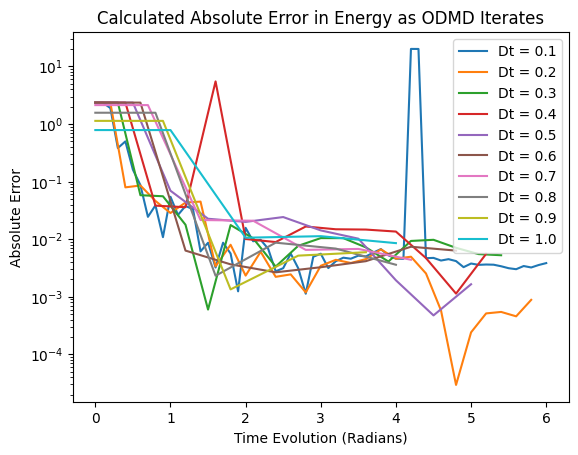

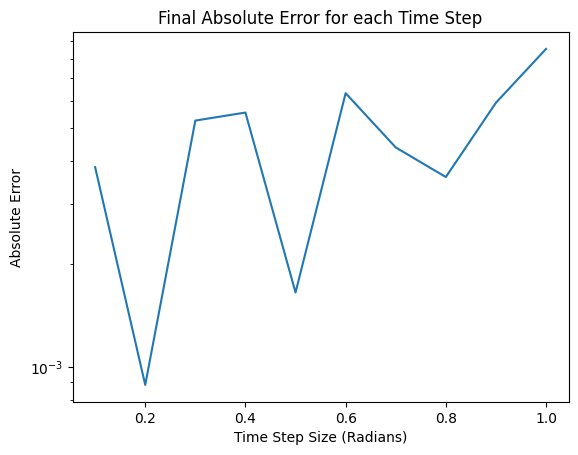

[-2.360035929875509, -2.3570779354054525, -2.3614560485211706, -2.3617491955991663, -2.3545460185083678, -2.349863616844101, -2.3518055496972656, -2.352600111155251, -2.362130321631213, -2.364729379470248]


In [27]:
real_E_0 = -abs(np.linalg.eigvals(Ham)[0].real)
for i in range(len(trials)):
    err = [abs(w-real_E_0) for w in trials[i]]
    plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], err, label = 'Dt = '+str(time_steps[i]))
plt.title("Calculated Absolute Error in Energy as ODMD Iterates")
plt.ylabel("Absolute Error")
plt.xlabel("Time Evolution (Radians)")
plt.legend()
# plt.ylim([0,.5])
plt.yscale('log')
plt.savefig("Absolute_Error_in_Energy.png")
plt.show()

plt.title("Final Absolute Error for each Time Step")
plt.xlabel("Time Step Size (Radians)")
plt.ylabel("Absolute Error")
plt.yscale('log')
plt.plot(time_steps, [abs(real_E_0-i) for i in results])
# plt.ylim([-abs(np.linalg.eigvals(Ham)[0].real)+.5,-abs(np.linalg.eigvals(Ham)[0].real)-.5])
plt.savefig("Final_Absolute_Error_Time_Step.png")
plt.show()
print(results)
